## <font color='turquoise'> Multivariate analysis (ISC)</font>

We again want to mask out our clips, but this time we want on the the NIM set of clips - the _non-internal monologue segments_, and we want the voxel-wise average across time. 

In [ ]:
import os
import pandas as pd 
import numpy as np
from natsort import natsorted

#Brain packages
import nibabel as nb
import nilearn
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

In [ ]:
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
                                                    data_dir=None, base_url=None, resume=True, verbose=1)
'''
From the documentation:
The list of labels does not contain ‘Background’ by default. 
To have proper indexing, you should either manually add ‘Background’ to the list of labels:
'''

schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

masker = NiftiLabelsMasker(
    labels_img=schaefer_atlas.maps,
    strategy='mean',  # Averages voxels in parcel at each TR
    standardize=False  # don't want z-scoring
)

In [68]:
version_matrix = np.loadtxt("version_matrix.csv",delimiter=",", dtype=int, encoding='utf-8-sig')

In [ ]:
segmented_clip_path = '/Volumes/LT/phd/inarr/'
sublist = [x for x in os.listdir(segmented_clip_path) if 'sub' in x]
complete_cliplist = []

#compile all of the clip files across subjects
for sub in sublist:
    try:
        segment_list = [x for x in os.listdir(segmented_clip_path+sub+os.sep+"segmented_files/") if "_NIM" in x]
        discard_first_clip = [x for x in segment_list if "_clip-0_" not in x]

        for f in discard_first_clip:
            complete_cliplist.append(f)
    except:
        continue

movie_list = ['physical', 'stutterer']

#we don't include the very first clip, clip-0:
nim_isc_clips = ['clip-2','clip-4','clip-6','clip-8','clip-10','clip-12',
             'clip-14','clip-16','clip-18','clip-20','clip-22','clip-24']

In [75]:
for movie in movie_list[1:2]:
    #all the subject's clips corresponding to stutterer, for example
    movie_cliplist = [x for x in complete_cliplist if movie in x]

    clip_to_version_correlation = np.zeros([12,400]) #NIM is 12 clips without the first one

    for ix, i in enumerate(nim_isc_clips):
        print("starting clip:", i)

        #all 28 subjects clip-1's for example
        filtered_clips = [x for x in movie_cliplist if i+"_" in x]

        #doing this ensures that my resulting matrix is in the *same exact order* as our version matrix
        v1_clips = natsorted([x for x in filtered_clips if 'version-1' in x])
        v2_clips = natsorted([x for x in filtered_clips if 'version-2' in x])

        single_clip_matrix_list = []

        for clip in v1_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            """ 
            masker.fit_transform(clip_segment_nii) will take the voxelwise mean (ie it preserves
            timecourse information). This produces a timepoint x parcel csv, eg for physical's 
            clip_0, it will generate a (74,40) shape.
            """

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            single_clip_matrix_list.append(time_by_parcel)
        
        for clip in v2_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            single_clip_matrix_list.append(time_by_parcel)
        
        single_clip_mat_arr = np.array(single_clip_matrix_list)

        for p in range(400):

            subject_by_timeseries = [] # eg., clip-2 has 28 subjects, and a timeseries of 14

            for subject in range(single_clip_mat_arr.shape[0]): #go through each subject
                subject_by_timeseries.append(single_clip_mat_arr[subject,:,p]) #grab the clip timeseries

            clipdf = pd.DataFrame(subject_by_timeseries)
            cliparr = np.corrcoef(clipdf)

            neural_lower = nilearn.connectome.sym_matrix_to_vec(cliparr, discard_diagonal=True)
            version_lower = nilearn.connectome.sym_matrix_to_vec(version_matrix, discard_diagonal=True)

            result = np.corrcoef(neural_lower, version_lower)[0][1]
            clip_to_version_correlation[ix,p] = result

    output = pd.DataFrame(clip_to_version_correlation)
    output.to_csv(movie+"_parcel_NIM_ISC.csv")

starting clip: clip-2
starting clip: clip-4
starting clip: clip-6
starting clip: clip-8
starting clip: clip-10
starting clip: clip-12
starting clip: clip-14
starting clip: clip-16
starting clip: clip-18
starting clip: clip-20
starting clip: clip-22
starting clip: clip-24


### Plotting the un-corrected results

In [82]:
phys_isc, stut_isc = pd.read_csv('physical_parcel_NIM_ISC.csv', index_col=0), pd.read_csv('stutterer_parcel_NIM_ISC.csv', index_col=0)
phys_isc_avg, stut_isc_avg = phys_isc.mean(axis=0).reset_index(drop=True), stut_isc.mean(axis=0).reset_index(drop=True)
isc_avg = list((phys_isc_avg + stut_isc_avg) / 2)

In [84]:
from nilearn import plotting, datasets, image, surface
import nibabel as nb
from nilearn.plotting import plot_img_on_surf
from nilearn.image import new_img_like

fsaverage = datasets.fetch_surf_fsaverage()

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
    data_dir=None, base_url=None, resume=True, verbose=1)

schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/schaefer_2018


In [85]:
atlas = nb.load(schaefer_atlas.maps) # .maps provides the path to the map
atlas_data = atlas.get_fdata()
affine = atlas.affine

mapped_data = np.zeros_like(atlas_data)
mapped_data[atlas_data == 0] = np.nan # mark
unique_regions = np.unique(atlas_data)[1:]

for i, region in enumerate(unique_regions):
    mapped_data[atlas_data == region] = isc_avg[i] 

isc_corr_map = nb.Nifti1Image(mapped_data, affine)
nb.save(isc_corr_map, 'isc_corr_map.nii.gz')

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/fsaverage


/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


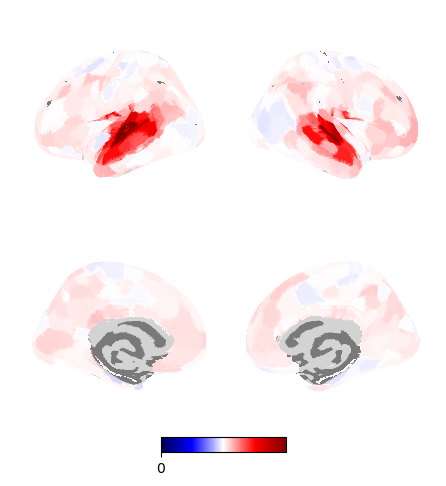

In [86]:
plotting.plot_img_on_surf(isc_corr_map,
    "fsaverage", inflate=True,
    views=['lateral', 'medial'],  # Hemispheric views to display
    hemispheres=['left', 'right'],  # Both hemispheres
    #threshold=0.05,  # Highlight significant p-values
    cmap='seismic',  # Colormap (e.g., 'viridis', 'coolwarm')
    colorbar=True,  # Show colorbar
    # vmin=0, vmax=.4, #removing these options to let it be automatic
)

plotting.show()

### Permutation Analyses

In [ ]:
for movie in movie_list[1:2]:
    #all the subject's clips corresponding to stutterer, for example
    movie_cliplist = [x for x in complete_cliplist if movie in x]

    clip_to_version_correlation = np.zeros([12,400, 10]) # (num. nim clips, num. parcels, num permutations)

    for ix, i in enumerate(nim_isc_clips):
        print("starting clip:", i)

        #all 28 subjects clip-1's for example
        filtered_clips = [x for x in movie_cliplist if i+"_" in x]

        #doing this ensures that my resulting matrix is in the *same exact order* as our version matrix
        v1_clips = natsorted([x for x in filtered_clips if 'version-1' in x])
        v2_clips = natsorted([x for x in filtered_clips if 'version-2' in x])

        single_clip_matrix_list = []

        for clip in v1_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            """ 
            masker.fit_transform(clip_segment_nii) will take the voxelwise mean (ie it preserves
            timecourse information). This produces a timepoint x parcel csv, eg for physical's 
            clip_0, it will generate a (74,40) shape.
            """

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            single_clip_matrix_list.append(time_by_parcel)
        
        for clip in v2_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            single_clip_matrix_list.append(time_by_parcel)
        
        single_clip_mat_arr = np.array(single_clip_matrix_list)

        for p in range(400):

            np.random.seed(0)

            subject_by_timeseries = [] # eg., clip-2 has 28 subjects, and a timeseries of 14

            for subject in range(single_clip_mat_arr.shape[0]): #go through each subject
                subject_by_timeseries.append(single_clip_mat_arr[subject,:,p]) #grab the clip timeseries

            clipdf = pd.DataFrame(subject_by_timeseries)
            cliparr = np.corrcoef(clipdf)

            for perm in range(10):
                shuffled_matrix = cliparr[np.random.permutation(28)][:, np.random.permutation(28)]

                neural_lower = nilearn.connectome.sym_matrix_to_vec(cliparr, discard_diagonal=True)
                version_lower = nilearn.connectome.sym_matrix_to_vec(version_matrix, discard_diagonal=True)

                result = np.corrcoef(neural_lower, version_lower)[0][1]
                clip_to_version_correlation[ix,p,perm] = result

        np.save(movie+'_isc_permutation_matrix', clip_to_version_correlation)

starting clip: clip-2
starting clip: clip-4
starting clip: clip-6
starting clip: clip-8
starting clip: clip-10
starting clip: clip-12
starting clip: clip-14
starting clip: clip-16
starting clip: clip-18
starting clip: clip-20
starting clip: clip-22
starting clip: clip-24


In [94]:
clip_to_version_correlation.max(axis=1)

array([[0.5375132 , 0.5375132 , 0.5375132 , 0.5375132 , 0.5375132 ,
        0.5375132 , 0.5375132 , 0.5375132 , 0.5375132 , 0.5375132 ],
       [0.22185808, 0.22185808, 0.22185808, 0.22185808, 0.22185808,
        0.22185808, 0.22185808, 0.22185808, 0.22185808, 0.22185808],
       [0.26376533, 0.26376533, 0.26376533, 0.26376533, 0.26376533,
        0.26376533, 0.26376533, 0.26376533, 0.26376533, 0.26376533],
       [0.62488555, 0.62488555, 0.62488555, 0.62488555, 0.62488555,
        0.62488555, 0.62488555, 0.62488555, 0.62488555, 0.62488555],
       [0.77855827, 0.77855827, 0.77855827, 0.77855827, 0.77855827,
        0.77855827, 0.77855827, 0.77855827, 0.77855827, 0.77855827],
       [0.40403732, 0.40403732, 0.40403732, 0.40403732, 0.40403732,
        0.40403732, 0.40403732, 0.40403732, 0.40403732, 0.40403732],
       [0.84350621, 0.84350621, 0.84350621, 0.84350621, 0.84350621,
        0.84350621, 0.84350621, 0.84350621, 0.84350621, 0.84350621],
       [0.17901838, 0.17901838, 0.1790183